In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
listings = pd.read_csv('listings_cleaned.csv',index_col = 0)
pd.set_option('display.max_columns', None)
listings.head(2)

,host_is_superhost,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,zipcode_cleaned,neighbourhood_listing_total,amenities_score
0,f,t,43.64617,-79.42451,House,Entire home/apt,10,3.0,5.0,7.0,469.0,1000.0,150.0,0.0,4,730,0,0,7,100.0,f,strict_14_with_grace_period,M6,484,5.0
1,f,f,43.64105,-79.37628,Apartment,Private room,2,1.5,1.0,1.0,99.0,2651.0,NaN,0.0,180,365,0,0,169,97.0,t,strict_14_with_grace_period,M5,4241,6.0


In [3]:
listings['zipcode_cleaned'].unique()

array(['M6', 'M5', 'M4', 'M1', 'M3', 'M8', 'M2', 'M9'], dtype=object)

In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22531 entries, 0 to 23397
Data columns (total 25 columns):
host_is_superhost              22531 non-null object
host_identity_verified         22531 non-null object
latitude                       22531 non-null float64
longitude                      22531 non-null float64
property_type                  22531 non-null object
room_type                      22531 non-null object
accommodates                   22531 non-null int64
bathrooms                      22525 non-null float64
bedrooms                       22507 non-null float64
beds                           22389 non-null float64
price                          22531 non-null float64
security_deposit               22531 non-null float64
cleaning_fee                   19143 non-null float64
extra_people                   22531 non-null float64
minimum_nights                 22531 non-null int64
maximum_nights                 22531 non-null int64
availability_30                22531 

In [5]:
target = ['price']

cat_features = ['host_is_superhost', 'host_identity_verified',
               'property_type', 'room_type', 'instant_bookable', 
                'cancellation_policy', 'zipcode_cleaned' ]  

num_features = ['latitude', 'longitude', 'accommodates', 
                'bathrooms', 'bedrooms', 'beds',
                'cleaning_fee', 'extra_people', 'security_deposit', 
                'minimum_nights', 'maximum_nights', 
                'availability_30', 'availability_365',
                'number_of_reviews', 'review_scores_rating',
                'amenities_score', 'neighbourhood_listing_total']

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(listings, test_size=0.3, random_state=100)
print('Train set:', train_set.shape)
print('Test set:', test_set.shape)

Train set: (15771, 25)
Test set: (6760, 25)


In [7]:
X_train = train_set.loc[:, train_set.columns != 'price']
y_train = train_set['price']
X_test = test_set.loc[:, test_set.columns != 'price']
y_test = test_set['price']

In [8]:
# Create a pipeline for numerical features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# Create a pipeline that only one hot encodes categorical features
full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_features),
        ("num", num_pipeline, num_features)
    ])

In [9]:
# Create the final input arrays for modeling

X_train = full_pipeline.fit_transform(X_train)
print('Train set: ', X_train.shape)

Train set:  (15771, 47)


In [10]:
X_test = full_pipeline.transform(X_test)
print('Test set: ', X_test.shape)

Test set:  (6760, 47)


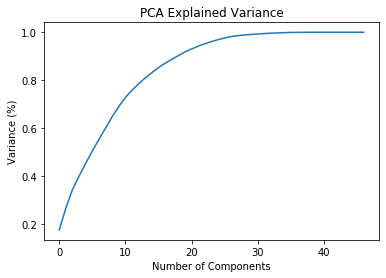

In [11]:
#Fitting the PCA algorithm with our Data
pca_g = PCA().fit(X_train)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca_g.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('PCA Explained Variance')
plt.show()

In [12]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [13]:
pca.n_components_

23

In [14]:
# Recalculate dataset using PCA model inverse transformation
X_reduced_inv = pca.inverse_transform(X_train_reduced)

In [15]:
# compute reconstruction loss
loss = ((X_train - X_reduced_inv) ** 2).mean()
loss

0.021363482419692305

In [16]:
# we lost about 4.78% of the variance:
1 - pca.explained_variance_ratio_.sum()

0.047846345904472565

In [17]:
X_test_reduced = pca.transform(X_test)

### Model Training

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

!pip3 install xgboost

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [29]:
def calculate_cross_validation(model, X_train, y_train):
        score = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
        rmse_score = np.sqrt(-score)
        print("Cross Validation Score: " + str(rmse_score))
        print("Mean: " + str(rmse_score.mean()))
        print("Std Deviation: " + str(rmse_score.std()) )

In [30]:
def evaluate_model(model, X_test_param, y_test_param):
    print(model.__class__.__name__)
    y_predict = model.predict(X_test_param)
    print("MAE: " + str(mean_absolute_error(y_test_param, y_predict)))
    RMSE = np.sqrt(mean_squared_error(y_test_param, y_predict))
    print("RMSE: " + str(RMSE)) 
    print("R2: " + str(r2_score(y_test_param, y_predict)))
  #  calculate_cross_validation(model, X_train_param, y_train_param)
    print("---------")

In [31]:
def init_models():
    return [LinearRegression(),
            Lasso(),
            Ridge(),
            RandomForestRegressor(n_estimators=100),
            ElasticNet(),
            SVR(gamma='auto'),
            SVR(kernel="poly", degree=2),
            XGBRegressor()]


In [32]:
models = init_models()

In [33]:
for m in models:
    m.fit(X_train_reduced, y_train)
    evaluate_model(m, X_test_reduced, y_test)

LinearRegression
MAE: 61.543634523614415
RMSE: 205.25456653358012
R2: 0.14533092522452562
---------
Lasso
MAE: 60.504075550520476
RMSE: 205.1664944753141
R2: 0.1460642225791834
---------
Ridge
MAE: 61.54251731851448
RMSE: 205.2543720313253
R2: 0.14533254501780202
---------
RandomForestRegressor
MAE: 62.46930177514793
RMSE: 217.61496352530162
R2: 0.039295459973503144
---------
ElasticNet
MAE: 59.49976446455853
RMSE: 205.34987651652372
R2: 0.1445370095621722
---------
SVR
MAE: 53.791432900013234
RMSE: 212.07172756148984
R2: 0.08761553520038479
---------


/Users/leilafidelino/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR
MAE: 62.393649080073274
RMSE: 215.1652062745397
R2: 0.060803594205032896
---------
XGBRegressor
MAE: 59.35224926147235
RMSE: 212.37183805697242
R2: 0.08503141047425133
---------


In [34]:
# Grid search for Elastic Net
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000],
               'l1_ratio': [0.2, 0.5, 0.8]}]
gs_eln = GridSearchCV(ElasticNet(max_iter=30000, tol=0.1), param_grid, cv=5, scoring='neg_mean_squared_error')
gs_eln.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=30000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000], 'l1_ratio': [0.2, 0.5, 0.8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [35]:
print(gs_eln.best_params_)
print(np.sqrt(-gs_eln.best_score_))

{'alpha': 0.001, 'l1_ratio': 0.2}
252.06019680551879


In [36]:
# test on test set
final_model = gs_eln.best_estimator_
y_te_pred = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_te_pred)
final_rmse = np.sqrt(final_mse)
print("RMSE: " + str(final_rmse))
print("MAE: " + str(mean_absolute_error(y_test, y_te_pred)))

RMSE: 204.69533397077473
MAE: 60.85194900934445


### Neural Networks

In [37]:
pd.DataFrame(data = X_train_reduced).shape

(15771, 23)

In [38]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Cloning https://github.com/tensorflow/docs to /private/var/folders/rz/khx0ym5s6mqbvqqr3q5bq6800000gn/T/pip-req-build-iahb7s7v
  Stored in directory: /private/var/folders/rz/khx0ym5s6mqbvqqr3q5bq6800000gn/T/pip-ephem-wheel-cache-arb_8o25/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [39]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[23]),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.018)

model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [40]:
history = model.fit(
  X_train_reduced, y_train,
  epochs=1000, validation_split = 0.2, callbacks=[callback], verbose=0)

In [41]:
model.evaluate(X_test_reduced, y_test)

6760/6760 [==============================] - 0s 15us/sample - loss: 46631.7685 - mae: 54.7595 - mse: 46631.7734


[46631.7685243505, 54.759514, 46631.773]

Text(0, 0.5, 'MAE')

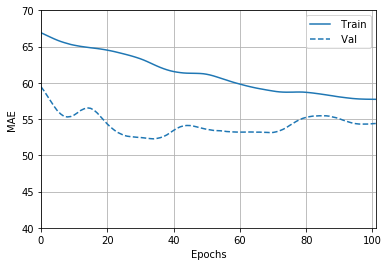

In [42]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'': history}, metric = "mae")
plt.ylim([40, 70])
plt.ylabel('MAE')

### Conclusion

From notebook 1, we can see that the top features that contribute to a higher AirBnb pricing is latitude/longitude, accommodates, cleaning_fee and property_type. This makese intuitive sense because the location of the property, how many people it can accomodates, the amount of money it requires for cleanup, and the type of the property can have a big impact on the price of the Airbnb listing.
For the model it appears that our Neural Network model has the lowest error. This model can continue to be tweaked via adjusting parameters such as the layers, learning rate, opitmizers, etc.